In [3]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    RandomFlip, RandomRotation, RandomZoom, Input, Conv2DTranspose, Reshape,
    UpSampling2D
)
from keras.losses import mean_squared_error


In [4]:
class WildfireAutoencoder:
    def __init__(self, img_size=64, latent_dim=128):
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.history = None
        
    def load_and_preprocess_data(self, train_dir, valid_dir, test_dir):
        """Load and preprocess images from directories"""
        def load_data_from_dir(directory):
            x_data = []
            for class_name in os.listdir(directory):
                class_dir = os.path.join(directory, class_name)
                for filename in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, filename)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (self.img_size, self.img_size))
                    img = img / 255.0  # Normalize
                    x_data.append(img)
            return np.array(x_data)

        print("Loading training data...")
        self.x_train = load_data_from_dir(train_dir)
        print("Loading validation data...")
        self.x_val = load_data_from_dir(valid_dir)
        print("Loading test data...")
        self.x_test = load_data_from_dir(test_dir)
    
    def build_model(self):
        """Build the autoencoder model (encoder + decoder)"""
        # Create data augmentation layer
        data_augmentation = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.2),
            RandomZoom(0.2),
        ])
        
        # Calculate dimensions after encoding
        # After 3 max pooling layers (2x2), the image size reduces by 2^3 = 8 times
        encoded_dim = self.img_size // 8
        
        # Build the encoder
        encoder_inputs = Input(shape=(self.img_size, self.img_size, 3))
        x = data_augmentation(encoder_inputs)
        
        # Encoding path (similar to the CNN part of the original model)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        
        # Store the shape before flattening
        shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
        
        # Flatten and encode to latent space
        x = Flatten()(x)
        encoded = Dense(self.latent_dim, activation='relu')(x)
        
        # Build the encoder model
        self.encoder = Model(encoder_inputs, encoded, name='encoder')
        
        # Build the decoder
        latent_inputs = Input(shape=(self.latent_dim,))
        
        # Reconstruct the shape before flattening
        x = Dense(np.prod(shape_before_flatten), activation='relu')(latent_inputs)
        x = Reshape(shape_before_flatten)(x)
        
        # Decoding path (mirror of the encoding path with transpose convolutions)
        x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        
        # Output layer
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        
        # Build the decoder model
        self.decoder = Model(latent_inputs, decoded, name='decoder')
        
        # Build the full autoencoder
        autoencoder_outputs = self.decoder(self.encoder(encoder_inputs))
        self.autoencoder = Model(encoder_inputs, autoencoder_outputs, name='autoencoder')
        
        # Learning rate schedule
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=10000, decay_rate=0.9
        )
        optimizer = Adam(learning_rate=lr_schedule)
        
        # Compile model with MSE loss (standard for autoencoders)
        self.autoencoder.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mse']
        )
        
        return self.autoencoder
    
    def train(self, epochs=50, batch_size=32):
        """Train the autoencoder model"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )
        ]
        
        # Train to reconstruct the same images
        self.history = self.autoencoder.fit(
            self.x_train, self.x_train,
            validation_data=(self.x_val, self.x_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
    
    def evaluate(self):
        """Evaluate the autoencoder and display results"""
        # Reconstruct test images
        reconstructed_imgs = self.autoencoder.predict(self.x_test)
        
        # Calculate test MSE
        test_loss = self.autoencoder.evaluate(self.x_test, self.x_test)
        print(f'\nTest Loss (MSE): {test_loss[0]:.4f}')
        
        # Display original and reconstructed images
        n = 10  # Number of images to display
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Original image
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(self.x_test[i])
            plt.title("Original")
            plt.axis('off')
            
            # Reconstructed image
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed_imgs[i])
            plt.title("Reconstructed")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Visualize latent space (optional)
        self.visualize_latent_space()
    
    def visualize_latent_space(self, n_samples=1000):
        """Visualize the latent space representations"""
        # Generate latent representations
        latent_representations = self.encoder.predict(self.x_test[:n_samples])
        
        # Use PCA or t-SNE to reduce to 2D if latent_dim > 2
        if self.latent_dim > 2:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            latent_2d = pca.fit_transform(latent_representations)
        else:
            latent_2d = latent_representations
        
        plt.figure(figsize=(10, 8))
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], cmap='viridis', alpha=0.6)
        plt.colorbar()
        plt.title('Latent Space Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath_prefix):
        """
        Save the encoder, decoder and full autoencoder
        
        Args:
            filepath_prefix (str): Path prefix for saving the models
        """
        # Check if models are built
        if self.encoder is None or self.decoder is None or self.autoencoder is None:
            raise ValueError("Models are not built yet. Call build_model() before saving.")
        
        try:
            print("Saving encoder...")
            self.encoder.save(f'{filepath_prefix}_encoder.keras')
            
            print("Saving decoder...")
            self.decoder.save(f'{filepath_prefix}_decoder.keras')
            
            print("Saving autoencoder...")
            self.autoencoder.save(f'{filepath_prefix}_autoencoder.keras')
            
            print(f"Models successfully saved to {filepath_prefix}_*.keras files")
        except Exception as e:
            print(f"Error saving models: {str(e)}")
            # Alternative: try H5 format if .keras fails
            try:
                print("Attempting to save in H5 format...")
                self.encoder.save(f'{filepath_prefix}_encoder.h5')
                self.decoder.save(f'{filepath_prefix}_decoder.h5')
                self.autoencoder.save(f'{filepath_prefix}_autoencoder.h5')
                print(f"Models successfully saved to {filepath_prefix}_*.h5 files")
            except Exception as e2:
                print(f"Error saving in H5 format: {str(e2)}")
        
    def load_from_saved_model(self, filepath_prefix):
        """
        Load a model from TensorFlow SavedModel format into Keras 3 using TFSMLayer.
        This is for loading existing SavedModel format models in Keras 3.
        
        Args:
            filepath_prefix (str): Path prefix for the saved models
        """
        try:
            # For loading the autoencoder
            print("Loading autoencoder from SavedModel using TFSMLayer...")
            autoencoder_layer = tf.keras.layers.TFSMLayer(
                f'{filepath_prefix}_autoencoder', 
                call_endpoint='serving_default'
            )
            
            # Create a new Keras model wrapping the TFSMLayer
            inputs = tf.keras.Input(shape=(self.img_size, self.img_size, 3))
            outputs = autoencoder_layer(inputs)
            self.autoencoder = tf.keras.Model(inputs, outputs)
            
            # Similar approach for encoder and decoder if needed
            # Note: You may need to adjust the call_endpoint based on your SavedModel
            
            print("Models successfully loaded from SavedModel format using TFSMLayer")
        except Exception as e:
            print(f"Error loading from SavedModel: {str(e)}")
            raise Exception(f"Failed to load models from SavedModel: {str(e)}")

    
    def encode_image(self, image_path):
        """Encode a single image to its latent representation"""
        img = cv2.imread(image_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        
        # Encode the image
        latent_vector = self.encoder.predict(img)
        
        return latent_vector
    
    def reconstruct_image(self, image_path):
        """Reconstruct a single image through the autoencoder"""
        img = cv2.imread(image_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        
        # Encode and then decode the image
        reconstructed = self.autoencoder.predict(img)
        
        # Calculate reconstruction error (MSE)
        reconstruction_error = np.mean(np.square(img - reconstructed))
        
        return {
            'original': img[0],
            'reconstructed': reconstructed[0],
            'reconstruction_error': float(reconstruction_error)
        }
    
    def detect_anomalies(self, test_dir, threshold=None):
        """
        Detect potential anomalies (wildfires) based on reconstruction error
        Higher reconstruction error may indicate anomalies (wildfires)
        """
        # Load test images
        test_images = []
        image_paths = []
        
        for class_name in os.listdir(test_dir):
            class_dir = os.path.join(test_dir, class_name)
            class_label = 1 if class_name == 'wildfire' else 0
            
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (self.img_size, self.img_size))
                img = img / 255.0
                
                test_images.append((img, class_label))
                image_paths.append(img_path)
        
        # Calculate reconstruction errors
        reconstruction_errors = []
        true_labels = []
        
        for img, label in test_images:
            img_batch = np.expand_dims(img, axis=0)
            reconstructed = self.autoencoder.predict(img_batch)
            error = np.mean(np.square(img - reconstructed[0]))
            
            reconstruction_errors.append(error)
            true_labels.append(label)
        
        # If threshold not provided, calculate based on distribution
        if threshold is None:
            # Use mean + 2*std as a simple threshold
            threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
        
        # Predict anomalies based on threshold
        predicted_labels = [1 if error > threshold else 0 for error in reconstruction_errors]
        
        # Calculate metrics
        from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
        
        # Plot reconstruction error distribution
        plt.figure(figsize=(10, 6))
        plt.hist(
            [
                [err for i, err in enumerate(reconstruction_errors) if true_labels[i] == 0],
                [err for i, err in enumerate(reconstruction_errors) if true_labels[i] == 1]
            ],
            bins=30,
            label=['No Wildfire', 'Wildfire'],
            alpha=0.7
        )
        plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
        plt.legend()
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Count')
        plt.show()
        
        # Print confusion matrix and classification report
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (Anomaly Detection)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        print("\nClassification Report (Anomaly Detection):")
        print(classification_report(true_labels, predicted_labels))
        
        # ROC curve
        fpr, tpr, _ = roc_curve(true_labels, reconstruction_errors)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        return {
            'threshold': threshold,
            'reconstruction_errors': reconstruction_errors,
            'true_labels': true_labels,
            'predicted_labels': predicted_labels
        }

In [5]:
# Define the directories
train_dir = r'C:\Users\shash\Downloads\archive\train'     # Replace with your train directory
valid_dir = r'C:\Users\shash\Downloads\archive\valid'     # Replace with your validation directory
test_dir = r'C:\Users\shash\Downloads\archive\test'       # Replace with your test directory

In [6]:
# Create the autoencoder with the desired parameters
autoencoder = WildfireAutoencoder(img_size=64, latent_dim=128)

In [7]:
# Load and preprocess the data
autoencoder.load_and_preprocess_data(train_dir, valid_dir, test_dir)

Loading training data...
Loading validation data...
Loading test data...


In [9]:
try:
    model = autoencoder.build_model()
    print("Model built successfully!")
    print(model)
    
    # Check if the autoencoder attribute is properly set
    print("Autoencoder attribute:", autoencoder.autoencoder)
    
    if autoencoder.autoencoder is None:
        print("Autoencoder attribute is None, setting it manually...")
        autoencoder.autoencoder = model
except Exception as e:
    print(f"Error building model: {e}")

Model built successfully!
<Functional name=autoencoder, built=True>
Autoencoder attribute: <Functional name=autoencoder, built=True>


In [12]:
# Train the autoencoder
autoencoder.train(epochs=50, batch_size=32)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(autoencoder.history.history['mse'])
plt.plot(autoencoder.history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 1.38 GiB for an array with shape (30250, 64, 64, 3) and data type float32

197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0236 - mse: 0.0236

Test Loss (MSE): 0.0170


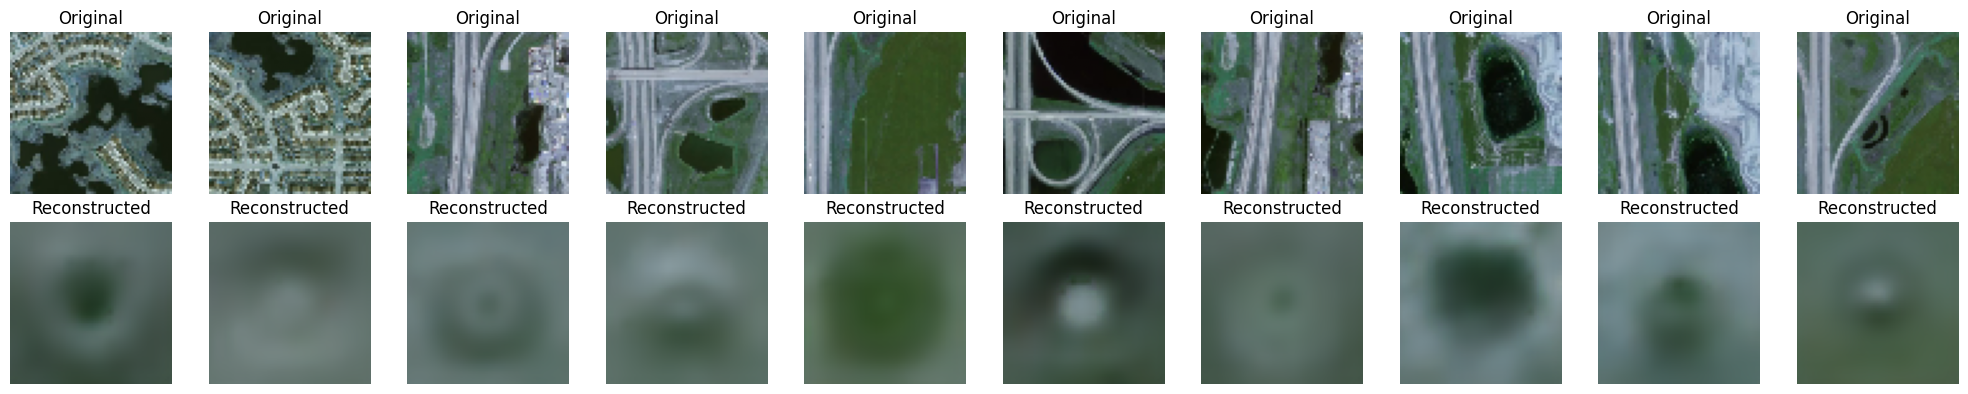

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Users\shash\AppData\Local\Temp\ipykernel_17124\1750562581.py:169: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_2d[:, 0], latent_2d[:, 1], cmap='viridis', alpha=0.6)


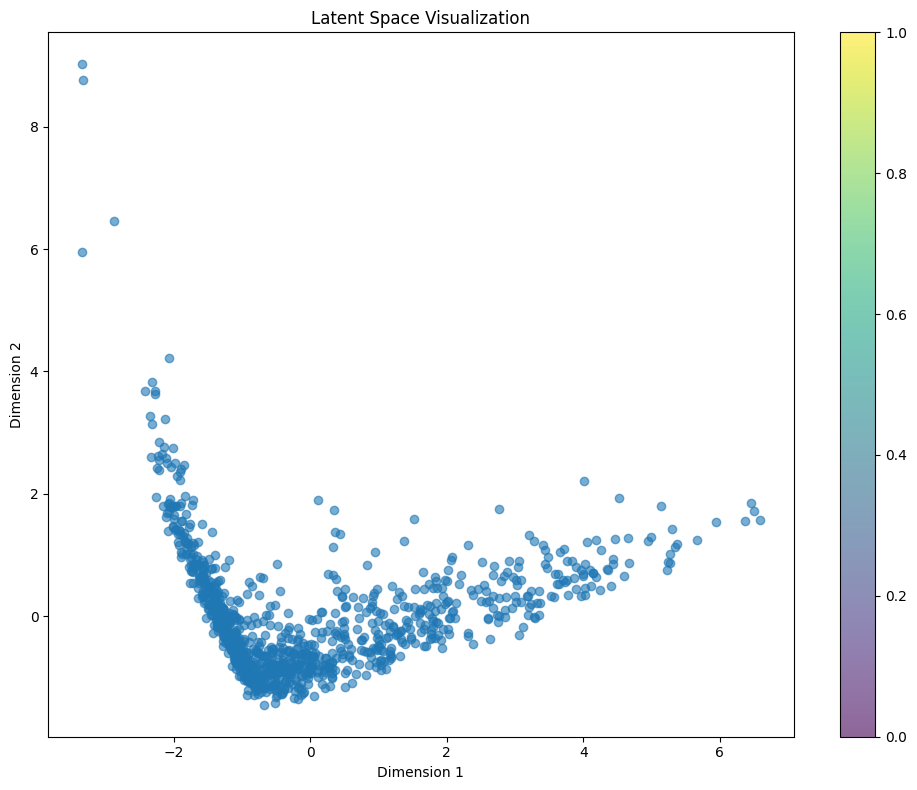

In [ ]:
# Evaluate the autoencoder
autoencoder.evaluate()

In [ ]:
autoencoder.save_model('wildfire_autoencoder')

ValueError: Models are not built yet. Call build_model() before saving.

In [ ]:
# Perform anomaly detection
results = autoencoder.detect_anomalies(test_dir)

# Print the threshold used for detection
print(f"Anomaly detection threshold: {results['threshold']:.6f}")

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
# Test on a single image
test_image_path = r'C:\BA\SEM4\EDA\ML\-79.25,46.95444.jpg'  # Update with your test image path
result = autoencoder.reconstruct_image(test_image_path)

# Display the original and reconstructed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(result['original'])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result['reconstructed'])
plt.title(f'Reconstructed\nError: {result["reconstruction_error"]:.4f}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Report whether it's likely to be a wildfire based on the reconstruction error
if result['reconstruction_error'] > results['threshold']:
    print(f"Detection: WILDFIRE DETECTED (Reconstruction Error: {result['reconstruction_error']:.4f})")
else:
    print(f"Detection: NO WILDFIRE (Reconstruction Error: {result['reconstruction_error']:.4f})")

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
# Later, load the model
autoencoder = WildfireAutoencoder(img_size=64, latent_dim=128)
autoencoder.load_from_saved_model('wildfire_autoencoder.h5')


Loading autoencoder from SavedModel using TFSMLayer...
Error loading from SavedModel: SavedModel file does not exist at: wildfire_autoencoder.h5_autoencoder\{saved_model.pbtxt|saved_model.pb}


Exception: Failed to load models from SavedModel: SavedModel file does not exist at: wildfire_autoencoder.h5_autoencoder\{saved_model.pbtxt|saved_model.pb}